### Homework 4 - Community Detection using Spectral Graph Theory
#### CSC 591 - GDM - Fall 2016
##### Unity ID: avshirod

**Put any package imports you need in the below space**

In [1]:
# Required imports
import numpy as np
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy.sparse import linalg as sp_linalg
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import random
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

----------------------------------------------

**Exercise 1**: Generating the data set. Generate a total of 60 points whose (x,y)-coordinates are drawn from a mixture of three Gaussians in a 2-dimentional real space. Each mixture has a mean of 2, 4, and 6, respectively, a standard deviation of one, and about 20 points.

(1) Plot all the points in a single 2-dimensional space by using different shapes for each mixture.

In [2]:
def points_gaus(mean, sd, n, offset, grp):
    x = np.round(np.random.normal(mean, sd, n),3)
    y = np.round(np.random.normal(mean, sd, n),3)
    xy = np.dstack((x,y))[0]
    xy = np.array([np.append([offset]+xy[i], grp) for i in range(len(x))])
    return xy

In [3]:
points1 = points_gaus(2,1,20,0,1)
points2 = points_gaus(4,1,20,0,2)
points3 = points_gaus(6,1,20,0,3)

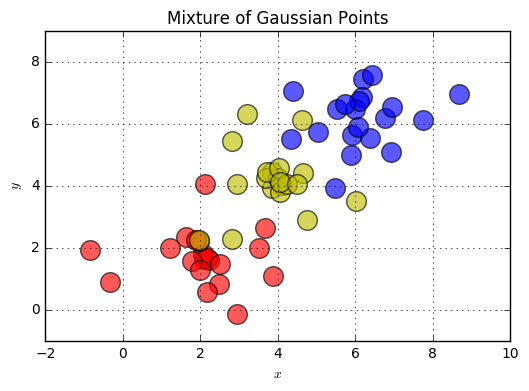

In [4]:
_ = plt.scatter(points1[:,0], points1[:,1], c='r', s=200, alpha=0.65)
_ = plt.scatter(points2[:,0], points2[:,1], c='y', s=200, alpha=0.65)
_ = plt.scatter(points3[:,0], points3[:,1], c='b', s=200, alpha=0.65)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Mixture of Gaussian Points')
plt.grid()

(2) Plot a histogram of all the points.

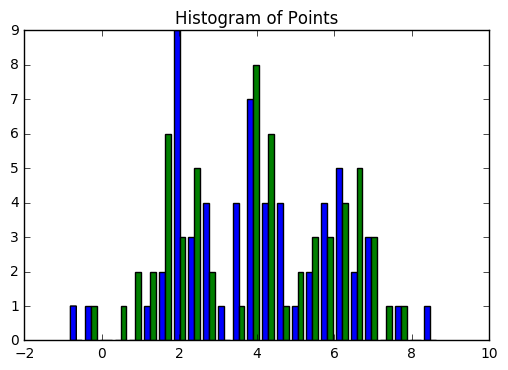

In [5]:
pts = np.concatenate((points1, points2, points3))
_ = plt.hist(pts[:,:2],25)
_ = plt.title("Histogram of Points")

In the above histogram, the blue bars indicate the 'x' co-ordinates, and red bars indicate the 'y' co-ordinates.

As we can see, all the points exhibit the normal (Gaussian) distribution.

-------------------------------------------------------

**Exercise 2**: Generating the similarity graphs. Write a script that generates the following similarity graphs for the data set in Exercise 1 (see Lecture Notes):

(1) KNN: The K-nearest neighbor graph using the value of K=10. Plot the graph.

In [6]:
knn_model = KNeighborsClassifier(n_neighbors=10)
pts_train = pts[np.random.choice(range(0,60), 40)]
knn_model.fit(pts_train[:,:2], pts_train[:,2])
labels = knn_model.predict(pts[:,:2])

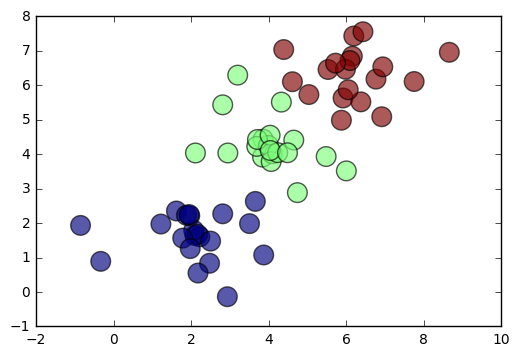

In [7]:
_ = plt.scatter(pts[:,0], pts[:,1], c=labels, s=200, alpha=0.65)

In [8]:
def adjmat_knn(labels):
    adjmat = []
    l = len(labels)
    for i in labels:
        entry = np.zeros(l)
        nbrs = np.where(labels == i)
        entry[nbrs] = 1
        entry[len(adjmat)] = 0
        adjmat.append(entry)
    return np.array(adjmat)

In [9]:
adj_knn = adjmat_knn(labels)
graph_knn = nx.from_numpy_matrix(adj_knn)

(2) GK: The complete similarity graph using the Gaussian kernel with sigma=1 as similarity function. Plot the graph.

In [10]:
def kernel_gaus(p1, p2, sigma=1):
    return np.exp(euclidean(p1, p2)/(-2*sigma))

In [11]:
def adjmat_gauss(points, sigma=1, threshold = 0.5):
    pair_dist = squareform(pdist(points, 'euclidean'))
    adjmat = np.exp(pair_dist**2/ (-2*sigma))
    adjmat_threshold = []
    for row in adjmat:
        row[row < threshold] = 0
        adjmat_threshold.append(row)
    return np.array(adjmat_threshold)

In [12]:
adj_gauss = adjmat_gauss(pts[:,:2], sigma=1)
graph_gauss = nx.from_numpy_matrix(adj_gauss)

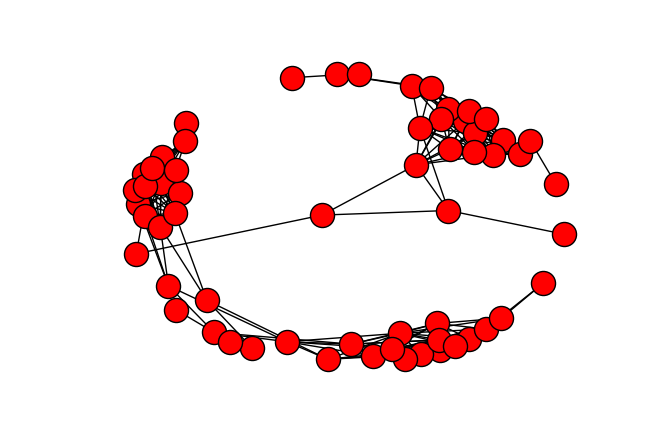

In [13]:
nx.draw(graph_gauss)

------------------------------------------------------

**Exercise 3**: Characterizing the graph spectra. Write a script that generates the graph Laplacian matrix L = D - A and the normalized graph Laplacian matrix $\hat{L} = I - \hat{A}$ and calculates the graph spectra for each of the graphs in Exercise 2.

Plot each graph's eigenspectra as a separate figure with i as x-axis and $\lambda_i$ as y-axis (four lines).


In [14]:
def calc_graph_spectra(graph):
    L = nx.laplacian_matrix(graph)
    L_hat = nx.normalized_laplacian_matrix(graph)
    eigen_lapl = nx.laplacian_spectrum(graph)
    while True:
        try:
            _, eigenvec_lapl = sp_linalg.eigs(L,k=50,which='LR')
            break
        except sp_linalg.ArpackError:
            pass
    while True:
        try:
            eigen_norm_lapl, eigenvec_norm_lapl = sp_linalg.eigs(L_hat,k=50,which='LR')
            break
        except (sp_linalg.ArpackNoConvergence, sp_linalg.ArpackError):
            pass
    return L, L_hat, eigen_lapl, eigen_norm_lapl.real, eigenvec_lapl, eigenvec_norm_lapl

In [15]:
l_knn, lnorm_knn, eigen_knn, eigen_norm_knn, eigenvec_knn, eigenvec_norm_knn = calc_graph_spectra(graph_knn)
l_gauss, lnorm_gauss, eigen_gauss, eigen_norm_gauss, eigenvec_gauss, eigenvec_norm_gauss = calc_graph_spectra(graph_gauss)

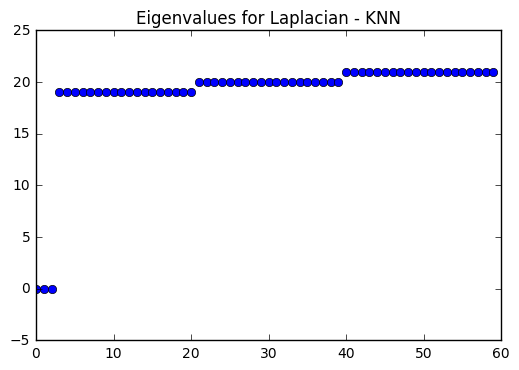

In [16]:
_ = plt.plot(list(range(len(eigen_knn))), eigen_knn,'o', c='b')
_ = plt.title("Eigenvalues for Laplacian - KNN")

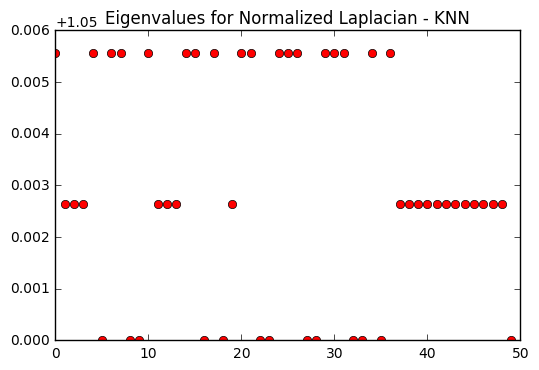

In [17]:
_ = plt.plot(list(range(len(eigen_norm_knn))), eigen_norm_knn,'o', c='r')
_ = plt.title("Eigenvalues for Normalized Laplacian - KNN")

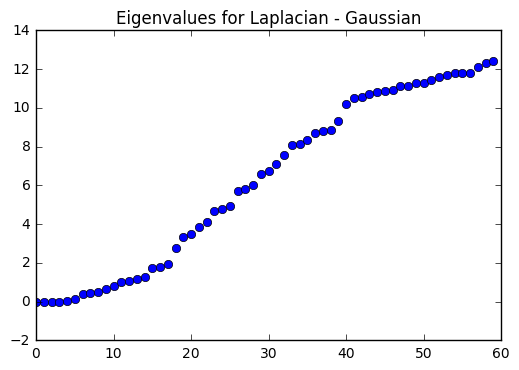

In [18]:
_ = plt.plot(list(range(len(eigen_gauss))), eigen_gauss,'o')
_ = plt.title("Eigenvalues for Laplacian - Gaussian")

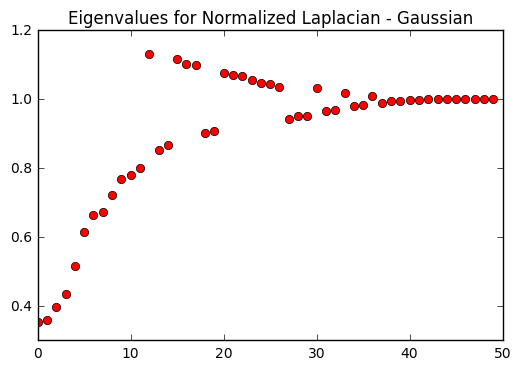

In [19]:
_ = plt.plot(list(range(len(eigen_norm_gauss))), eigen_norm_gauss,'o', c='r')
_ = plt.title("Eigenvalues for Normalized Laplacian - Gaussian")

*What do you observe about the multiplicity of the "close to" zero eigenvalues? Are your observations consistent with the Properties described in lecture notes?*

**Answer:**

We had created points from three separate Gaussian clusters. Therefore we should see atleast first three eigenvalues close to zero. This is clearly visible in the Eigenvalue scatters of Laplacian for both graphs.

Plot each graph's eigenvector plot for the eigenvector u corresponding to the second smallest eigenvalue, with i as x-axis and u_i vector component as y-axis.

Points below Threshold = [4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 20, 22, 23, 24, 25, 26, 29, 30, 31, 33, 37, 38, 41, 43, 44]
Corresponding Clusters = Counter({2: 12, 1: 11, 3: 3})


C:\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


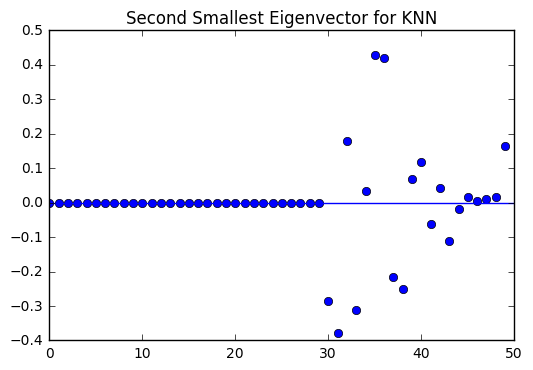

In [20]:
second_smallest_eigenvec_knn = eigenvec_knn[1]
_ = plt.plot(second_smallest_eigenvec_knn,'o')
_ = plt.title("Second Smallest Eigenvector for KNN")
_ = plt.axhline(0)

below_threshold_knn = list(np.where(second_smallest_eigenvec_knn < 0)[0])
below_threshold_labels = list(map(int,list(pts[below_threshold_knn][:,2])))
print("Points below Threshold = %r" % below_threshold_knn)
print("Corresponding Clusters = %r" % Counter(below_threshold_labels))

Points below Threshold = [4, 5, 9, 10, 14, 16, 17, 18, 21, 22, 24, 26, 30, 35, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48]
Corresponding Clusters = Counter({2: 9, 1: 8, 3: 7})


C:\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


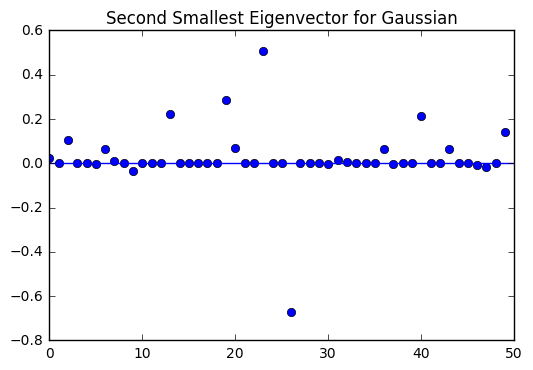

In [21]:
second_smallest_eigenvec_gauss = eigenvec_gauss[1]
_ = plt.plot(second_smallest_eigenvec_gauss,'o')
_ = plt.title("Second Smallest Eigenvector for Gaussian")
_ = plt.axhline(0)

below_threshold_gauss = list(np.where(second_smallest_eigenvec_gauss < 0)[0])
below_threshold_labels = list(map(int,list(pts[below_threshold_gauss][:,2])))
print("Points below Threshold = %r" % below_threshold_gauss)
print("Corresponding Clusters = %r" % Counter(below_threshold_labels))

C:\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Points below Threshold = [3, 5, 6, 8, 10, 15, 17, 20, 23, 24, 25, 29, 30, 31, 32, 33, 35, 38, 39, 40, 43, 45, 46, 47, 48, 49]
Corresponding Clusters = Counter({2: 12, 1: 7, 3: 7})


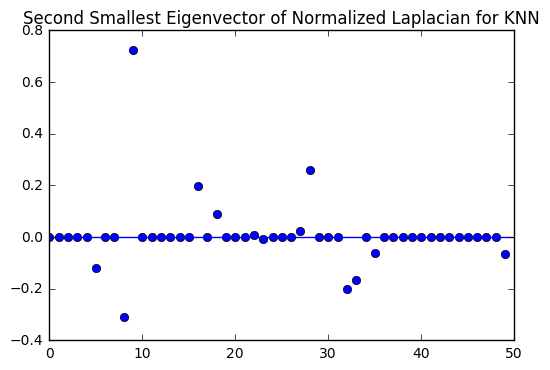

In [22]:
index_ = list(eigen_norm_knn).index(sorted(eigen_norm_knn)[-2])
second_smallest_eigenvec_norm_lapl_knn = eigenvec_norm_knn[index_]
_ = plt.plot(second_smallest_eigenvec_norm_lapl_knn,'o')
_ = plt.title("Second Smallest Eigenvector of Normalized Laplacian for KNN")
_ = plt.axhline(0)

below_threshold_norm_knn = list(np.where(second_smallest_eigenvec_norm_lapl_knn < 0)[0])
below_threshold_labels = list(map(int,list(pts[below_threshold_norm_knn][:,2])))
print("Points below Threshold = %r" % below_threshold_norm_knn)
print("Corresponding Clusters = %r" % Counter(below_threshold_labels))

Points below Threshold = [2, 8, 9, 11, 12, 13, 15, 17, 21, 22, 23, 25, 29, 30, 32, 34, 35, 38, 40, 42, 43, 45, 46, 48, 49]
Corresponding Clusters = Counter({2: 10, 1: 8, 3: 7})


C:\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


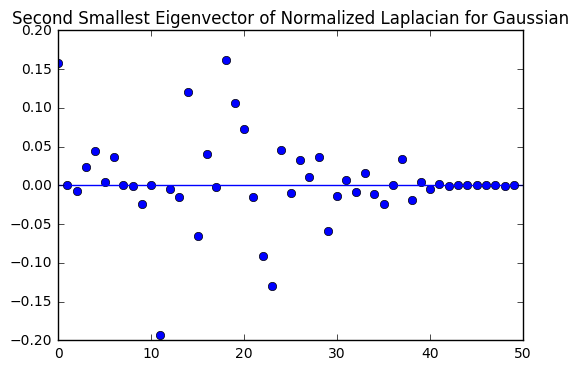

In [23]:
index_ = list(eigen_norm_gauss).index(sorted(eigen_norm_gauss)[-2])
second_smallest_eigenvec_norm_lapl_gauss = eigenvec_norm_gauss[index_]
_ = plt.plot(second_smallest_eigenvec_norm_lapl_gauss,'o')
_ = plt.title("Second Smallest Eigenvector of Normalized Laplacian for Gaussian")
_ = plt.axhline(0)

below_threshold_norm_gauss = list(np.where(second_smallest_eigenvec_norm_lapl_gauss < 0)[0])
below_threshold_labels = list(map(int,list(pts[below_threshold_norm_gauss][:,2])))
print("Points below Threshold = %r" % below_threshold_norm_gauss)
print("Corresponding Clusters = %r" % Counter(below_threshold_labels))

*If you were using this plot for 2-way graph partitioning into S and V-S, the points from which mixtures will end up in which partition?*

**Answer:**

We can see the partitioning above, with threshold set to 0.
All points below that threshold are in one partition (say S), and others in (V-S).

Calculate the conductance (write the script) for each of the identified partitions, S and V-S for the KNN graph using both the normalized and unnormalized Laplacian. Also, calculate the lower and upper bounds for the graph conductance using the inequalities provided in the lecture notes. Print the results of these calculations (make sure to label them).

In [24]:
def get_conductance(g, s_nodes):
    n = g.nodes()
    v_s_nodes = list(set(n).difference(set(s_nodes)))
    
    s = g.copy()
    s.remove_nodes_from(v_s_nodes)
    
    v_s = g.copy()
    v_s.remove_nodes_from(s_nodes)
    
    m = len(s.edges())
    c = len(g.edges()) - len(v_s.edges()) - len(s.edges())
    
    return c/(2*m + c)

In [25]:
print("Conductance(S, KNN, Laplacian) = \t %r" % get_conductance(graph_knn, below_threshold_knn))
print("Conductance(V-S, KNN, Laplacian) = \t %r" % get_conductance(graph_knn,[i for i in range(60) if i not in below_threshold_knn]))

print("Conductance(S, KNN, Norm Laplacian) = \t %r" % get_conductance(graph_knn, below_threshold_norm_knn))
print("Conductance(V-S, KNN, Norm Laplacian) =  %r" % get_conductance(graph_knn, [i for i in range(60) if i not in below_threshold_norm_knn]))

Conductance(S, KNN, Laplacian) = 	 0.5369261477045908
Conductance(V-S, KNN, Laplacian) = 	 0.41965678627145087
Conductance(S, KNN, Norm Laplacian) = 	 0.562753036437247
Conductance(V-S, KNN, Norm Laplacian) =  0.42901234567901236


In [26]:
# Lower and Upper bounds for Conductance
e = np.sort(eigen_norm_knn)[1]
print("Bounds on Conductance for KNN Graph:")
print(str(e/2) + " < Conductance < " + str(np.sqrt(2*e)))

Bounds on Conductance for KNN Graph:
0.525 < Conductance < 1.44913767462


------------------------------------------------

**Exercise 4**: Spectral graph clustering. Write a script that performs spectral graph clustering using the normalized graph Laplacian of each of the graph in Exercise 2. The pseudo-code of the clustering method is described in the lecture notes. For the k-means clustering method use the value of k=3. Run the spectral graph clustering and plot the corresponding points in Ex.1 with the shapes based on the identified cluster (one plot for each graph). In addition, run the k-means clustering algorithm on the data set in Exercise 1, using the Euclidean distance as the dissimilarity metric, and the value of k=3. Plot these results in 2-dimensional space but use different shape for each of the identified cluster. You should have three plots: two for each graph using spectral clustering, and one for k-means on the original data.

In [27]:
def smallest_eig_index(eigenval):
    e1, e2, e3 = 999.0, 999.0, 999.0
    idx_e1, idx_e2, idx_e3 = 0,0,0
    for i in range(len(eigenval)):
        if eigenval[i] <= e1:
            e3 = e2
            idx_e3 = idx_e2
            e2 = e1
            idx_e2 = idx_e1
            e1 = eigenval[i]
            idx_e1 = i
        elif eigenval[i] < e2:
            e3 = e2
            idx_e3 = idx_e2
            e2 = eigenval[i]
            idx_e2 = i
        elif eigenval[i] < e3:
            e3 = eigenval[i]
            idx_e3 = i
    return idx_e1, idx_e2, idx_e3

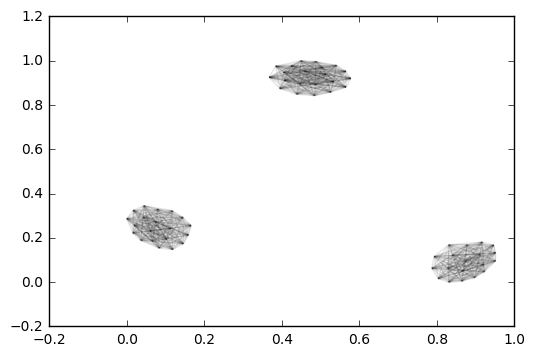

In [28]:
edges_knn = nx.draw_networkx_edges(graph_knn, pos = nx.spring_layout(graph_knn), alpha=0.1)

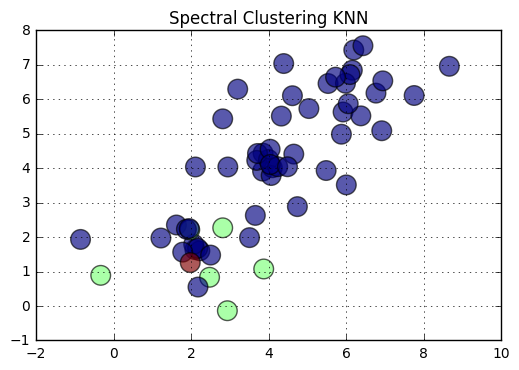

In [29]:
i1,i2,i3 = smallest_eig_index(eigen_norm_knn)
small_vec_knn = []
for j in range(len(eigenvec_norm_knn)):
    a = eigenvec_norm_knn.item((j,i1)).real
    b = eigenvec_norm_knn.item((j,i2)).real
    c = eigenvec_norm_knn.item((j,i3)).real
    small_vec_knn.append((a,b,c))
spec_clust_knn = KMeans(n_clusters=3).fit_predict(small_vec_knn)
_ = plt.scatter(pts[:,0], pts[:,1], c=spec_clust_knn, s=200, alpha=0.65)
_ = plt.title("Spectral Clustering KNN")
_ = plt.grid()

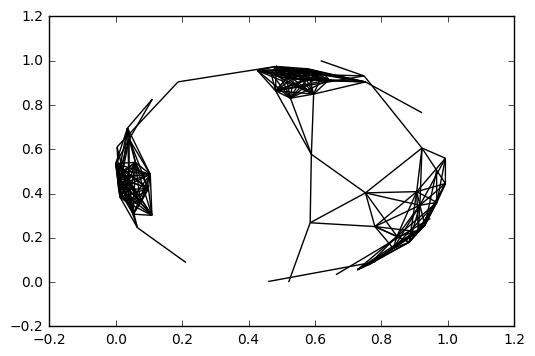

In [30]:
edges_gauss = nx.draw_networkx_edges(graph_gauss, pos=nx.spring_layout(graph_gauss))

Gauss Clusters = Counter({1: 52, 0: 7, 2: 1})


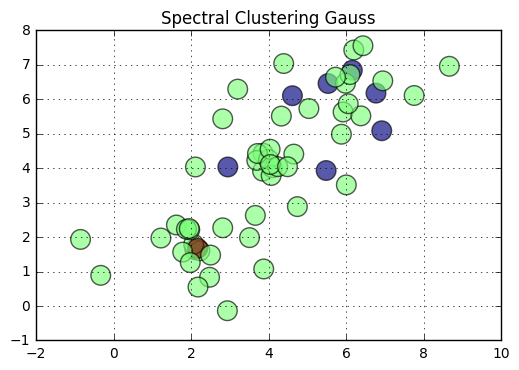

In [31]:
i1,i2,i3 = smallest_eig_index(eigen_norm_knn)
small_vec_gauss = []
for j in range(len(eigenvec_norm_gauss)):
    a = eigenvec_norm_gauss.item((j,i1)).real
    b = eigenvec_norm_gauss.item((j,i2)).real
    c = eigenvec_norm_gauss.item((j,i3)).real
    small_vec_gauss.append((a,b,c))
spec_clust_gauss = KMeans(n_clusters=3).fit_predict(small_vec_gauss)
_ = plt.scatter(pts[:,0], pts[:,1], c=spec_clust_gauss, s=200, alpha=0.65)
_ = plt.title("Spectral Clustering Gauss")
_ = plt.grid()
print("Gauss Clusters =", Counter(spec_clust_gauss))

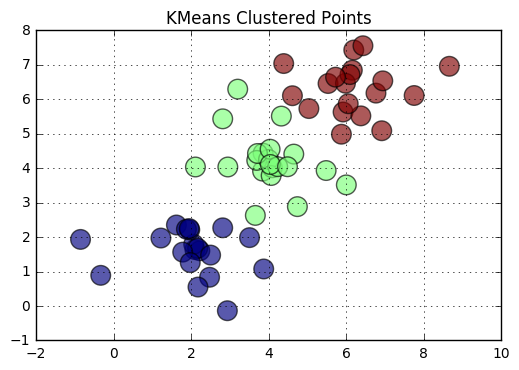

In [32]:
predict = KMeans(n_clusters=3).fit_predict(pts[:,:2])
_ = plt.scatter(pts[:,0], pts[:,1], c=predict, s=200, alpha=0.65)
_ = plt.title("KMeans Clustered Points")
_ = plt.grid()